#verify pyEMU results with the henry problem

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu

setting random seed


instaniate ```pyemu``` object and drop prior info.  Then reorder the jacobian and save as binary.  This is needed because the pest utilities require strict order between the control file and jacobian

In [2]:
la = pyemu.Schur("freyberg.jcb",verbose=False,forecasts=[])
la.drop_prior_information()
jco_ord = la.jco.get(la.pst.obs_names,la.pst.par_names)
ord_base = "freyberg_ord"
jco_ord.to_binary(ord_base + ".jco")  
la.pst.write(ord_base+".pst")

extract and save the forecast sensitivity vectors

In [3]:
pv_names = []
predictions =  ["sw_gw_0","sw_gw_1","or28c05_0","or28c05_1"]
for pred in predictions:
    pv = jco_ord.extract(pred).T
    pv_name = pred + ".vec"
    pv.to_ascii(pv_name)
    pv_names.append(pv_name)
    

save the prior parameter covariance matrix as an uncertainty file

In [4]:
prior_uncfile = "pest.unc"
la.parcov.to_uncfile(prior_uncfile,covmat_file=None)

#PRECUNC7
write a response file to feed ```stdin``` to ```predunc7```

In [7]:
post_mat = "post.cov"
post_unc = "post.unc"
args = [ord_base + ".pst","1.0",prior_uncfile,
        post_mat,post_unc,"1"]
pd7_in = "predunc7.in"
f = open(pd7_in,'w')
f.write('\n'.join(args)+'\n')
f.close()
out = "pd7.out"
pd7 = os.path.join("i64predunc7.exe")
os.system(pd7 + " <" + pd7_in + " >"+out)
for line in open(out).readlines():
    print(line)



 PREDUNC7 Version 13.6. Watermark Numerical Computing.



 Enter name of PEST control file:  Enter observation reference variance: 

 Enter name of prior parameter uncertainty file: 

 Enter name for posterior parameter covariance matrix file:  Enter name for posterior parameter uncertainty file: 

 Use which version of linear predictive uncertainty equation:-

     if version optimized for small number of parameters   - enter 1

     if version optimized for small number of observations - enter 2

 Enter your choice: 

 - reading PEST control file freyberg_ord.pst....

 - file freyberg_ord.pst read ok.



 - reading Jacobian matrix file freyberg_ord.jco....

 - file freyberg_ord.jco read ok.



 - reading parameter uncertainty file pest.unc....

 - parameter uncertainty file pest.unc read ok.

 - forming XtC-1(e)X matrix....

 - inverting prior C(p) matrix....

 - inverting [XtC-1(e)X + C-1(p)] matrix....

 - writing file post.cov...

 - file post.cov written ok.

 - writing file po

load the posterior matrix written by ```predunc7```

In [8]:
post_pd7 = pyemu.Cov.from_ascii(post_mat)

la_ord = pyemu.Schur(jco=ord_base+".jco",predictions=predictions)
post_pyemu = la_ord.posterior_parameter
#post_pyemu = post_pyemu.get(post_pd7.row_names)

The cumulative difference between the two posterior matrices:

In [37]:
post_pd7.x

array([[  2.49751300e-03,   0.00000000e+00,  -2.97581700e+00, ...,
          1.61399320e-05,   2.22882440e-06,   0.00000000e+00],
       [  0.00000000e+00,   6.25000000e-02,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -2.97581700e+00,   0.00000000e+00,   1.22048670e+08, ...,
          3.16856200e+01,   9.12888200e+00,   0.00000000e+00],
       ..., 
       [  1.61399320e-05,   0.00000000e+00,   3.16856200e+01, ...,
          2.16676000e+02,  -1.28669750e-03,   0.00000000e+00],
       [  2.22882440e-06,   0.00000000e+00,   9.12888200e+00, ...,
         -1.28669750e-03,   2.16680700e+02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   2.16681000e+02]])

In [38]:
post_pyemu.x

array([[  2.49751299e-03,   3.34137005e-55,  -2.97581661e+00, ...,
          1.61399363e-05,   2.22882527e-06,   8.41654901e-53],
       [  3.34137008e-55,   6.25000000e-02,  -9.36010436e-50, ...,
         -1.05755284e-53,  -8.96083997e-55,  -2.12977755e-52],
       [ -2.97581667e+00,  -9.36010811e-50,   1.22048683e+08, ...,
          3.16856251e+01,   9.12889259e+00,  -2.41924236e-47],
       ..., 
       [  1.61399373e-05,  -1.05755289e-53,   3.16856366e+01, ...,
          2.16676042e+02,  -1.28669804e-03,  -2.87256582e-51],
       [  2.22882555e-06,  -8.96084513e-55,   9.12888559e+00, ...,
         -1.28669803e-03,   2.16680779e+02,  -3.90542011e-52],
       [  8.41654910e-53,  -2.12977755e-52,  -2.41924147e-47, ...,
         -2.87256572e-51,  -3.90541891e-52,   2.16681114e+02]])

-133.140454787
9.94003135711 -19.416048497


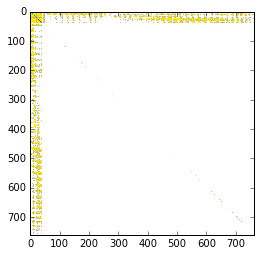

In [33]:

delta = (post_pd7 - post_pyemu).x
(post_pd7 - post_pyemu).to_ascii("delta.cov")
print(delta.sum())
print(delta.max(),delta.min())
delta = np.ma.masked_where(np.abs(delta) < 0.0001,delta)
plt.imshow(delta)

In [43]:
df = (post_pd7 - post_pyemu).to_dataframe().apply(np.abs)
df /= la_ord.pst.parameter_data.parval1
df *= 100.0
print(df.max())


rch_1       2.180424e-04
rch_2       1.236868e-45
rcond00     2.619607e-01
rcond01     2.410982e-01
rcond02     2.421514e-01
rcond03     2.012096e-01
rcond04     3.049383e-01
rcond05     2.386600e-01
rcond06     2.601344e-01
rcond07     3.662142e-01
rcond08     2.341057e-01
rcond09     8.802602e-02
rcond10     3.364413e-01
rcond11     2.480419e-01
rcond12     2.718080e-01
rcond13     2.749344e-01
rcond14     1.742944e-01
rcond15     1.905154e-01
rcond16     1.840580e-01
rcond17     3.294259e-01
rcond18     2.405401e-01
rcond19     3.958927e-01
rcond20     2.789328e-01
rcond21     1.434591e-01
rcond22     2.182171e-01
rcond23     1.265840e-01
rcond24     2.528860e-01
rcond25     2.292882e-01
rcond26     3.696230e-01
rcond27     3.446712e-01
                ...     
hkr37c10    6.895362e-03
hkr37c11    1.118996e-02
hkr37c12    5.598686e-03
hkr37c13    4.957369e-03
hkr37c14    2.090179e-03
hkr37c15    1.425463e-03
hkr37c16    1.366690e-03
hkr37c17    1.251194e-03
hkr38c05    4.613308e-03


In [29]:
delta

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -12.84752932190895 ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- -0.0001143765008180253]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True False ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True False]],
       fill_value = 1e+20)

A few more metrics ...

In [30]:
print((delta.sum()/post_pyemu.x.sum()) * 100.0)
print(np.abs(delta).sum())

-1.29714474919e-05
1494.97671749


#PREDUNC1
write a response file to feed ```stdin```.  Then run ```predunc1``` for each forecast

In [12]:
args = [ord_base + ".pst", "1.0", prior_uncfile, None, "1"]
pd1_in = "predunc1.in"
pd1 = os.path.join("i64predunc1.exe")
pd1_results = {}
for pv_name in pv_names:
    args[3] = pv_name
    f = open(pd1_in, 'w')
    f.write('\n'.join(args) + '\n')
    f.close()
    out = "predunc1" + pv_name + ".out"
    os.system(pd1 + " <" + pd1_in + ">" + out)
    f = open(out,'r')
    for line in f:
        if "pre-cal " in line.lower():
            pre_cal = float(line.strip().split()[-2])
        elif "post-cal " in line.lower():
            post_cal = float(line.strip().split()[-2])
    f.close()        
    pd1_results[pv_name.split('.')[0].lower()] = [pre_cal, post_cal]  
   
  

organize the ```pyemu``` results into a structure for comparison

In [13]:
# save the results for verification testing
pd.DataFrame(pd1_results).to_csv("predunc1_results.dat")

In [14]:
pyemu_results = {}
for pname in la_ord.prior_prediction.keys():
    pyemu_results[pname] = [np.sqrt(la_ord.prior_prediction[pname]),
                            np.sqrt(la_ord.posterior_prediction[pname])]

compare the results:

In [17]:
f = open("predunc1_textable.dat",'w')
for pname in pd1_results.keys():
    print(pname)
    f.write(pname+"&{0:6.5f}&{1:6.5}&{2:6.5f}&{3:6.5f}\\\n"\
            .format(pd1_results[pname][0],pyemu_results[pname][0],
                    pd1_results[pname][1],pyemu_results[pname][1]))
    print("prior",pname,pd1_results[pname][0],pyemu_results[pname][0])
    print("post",pname,pd1_results[pname][1],pyemu_results[pname][1])
f.close()

or28c05_1
prior or28c05_1 104.0399 104.039856267
post or28c05_1 103.9241 103.924143736
sw_gw_1
prior sw_gw_1 480268.8 480268.818236
post sw_gw_1 479750.0 479750.032693
or28c05_0
prior or28c05_0 91.25489 91.2548977153
post or28c05_0 30.53031 30.5303084385
sw_gw_0
prior sw_gw_0 96600.42 96600.4203489
post sw_gw_0 87527.32 87527.3190459


##PREDVAR1b
write the necessary files to run ```predvar1b```

In [45]:
f = open("pred_list.dat",'w')
out_files = []
for pv in pv_names:
    out_name = pv+".predvar1b.out"
    out_files.append(out_name)
    f.write(pv+" "+out_name+"\n")
f.close()
args = [ord_base+".pst","1.0","pest.unc","pred_list.dat"]
for i in range(36):
    args.append(str(i))
args.append('')    
args.append("n")
args.append("n")
args.append("y")
args.append("n")
args.append("n")
f = open("predvar1b.in", 'w')
f.write('\n'.join(args) + '\n')
f.close()




In [46]:
os.system("predvar1b.exe <predvar1b.in")

0

In [47]:
pv1b_results = {}
for out_file in out_files:
    pred_name = out_file.split('.')[0]
    f = open(out_file,'r')
    for _ in range(3):
        f.readline()
    arr = np.loadtxt(f)
    pv1b_results[pred_name] = arr


now for pyemu

In [48]:
omitted_parameters = [pname for pname in la.pst.parameter_data.parnme if pname.startswith("wf")]
la_ord_errvar = pyemu.ErrVar(jco=ord_base+".jco",
                             predictions=predictions,
                             omitted_parameters=omitted_parameters,
                             verbose=False)
df = la_ord_errvar.get_errvar_dataframe(np.arange(36))
df

first                                                  second  \
        or28c05_0     or28c05_1       sw_gw_0       sw_gw_1     or28c05_0   
0     8153.604880  1.669541e+02  5.428888e+09  2.864384e+09  0.000000e+00   
1     6269.494703  3.747366e+02  9.875784e+09  2.902774e+09  1.773993e-05   
2     3016.899493  1.109266e+03  9.687803e+09  2.902719e+09  2.962957e-05   
3     3139.705725  1.311422e+03  9.171667e+09  2.900768e+09  3.452397e-05   
4     2999.201766  9.768171e+02  1.019094e+10  2.898124e+09  3.560572e-05   
5     3044.123318  9.669220e+02  1.075065e+10  2.919239e+09  3.568542e-05   
6     3611.955321  1.633668e+03  1.217867e+10  2.893354e+09  3.732786e-05   
7     2342.509873  1.613037e+03  1.273572e+10  2.887671e+09  4.254574e-05   
8     2269.767333  2.687570e+03  2.362468e+10  2.974102e+09  4.275407e-05   
9     2249.327828  2.559921e+03  2.520462e+10  2.991163e+09  4.275464e-05   
10    2247.843431  2.560438e+03  2.509209e+10  2.990911e+09  4.275483e-05   
11    2350.978007  2.864368e+03  2.508755e+10  2.987628e+09  4.276376e-05   
12    2360.212072  3.366607e+03  2.727155e+10  2.997608e+09  4.278264e-05   
13    2467.761524  4.331432e+03  3.303477e+10  3.021873e+09  4.284878e-05   
14   26150.645386  5.495865e+08  3.334130e+10  3.629631e+14  1.000000e+35   
15   27138.548933  6.407106e+08  3.340429e+10  4.243142e+14  1.000000e+35   
16   27485.955527  6.768485e+08  3.366875e+10  4.486827e+14  1.000000e+35   
17   31552.377293  6.800044e+08  3.337181e+10  4.512717e+14  1.000000e+35   
18  108758.953214  9.901528e+08  3.312788e+10  6.638138e+14  1.000000e+35   
19  132807.387408  9.272681e+08  3.341504e+10  6.232348e+14  1.000000e+35   
20  123434.646439  5.578222e+08  3.332856e+10  3.736219e+14  1.000000e+35   
21  127352.790014  2.067882e+08  3.319365e+10  1.385714e+14  1.000000e+35   
22  118658.662512  1.079330e+08  3.246060e+10  7.354727e+13  1.000000e+35   
23  135670.148632  8.046849e+07  3.177958e+10  5.463347e+13  1.000000e+35   
24  133915.876611  6.013252e+07  3.170229e+10  4.096377e+13  1.000000e+35   
25  176628.007402  6.399439e+07  3.173799e+10  4.402236e+13  1.000000e+35   
26  266299.531015  6.258764e+07  3.174272e+10  4.280604e+13  1.000000e+35   
27  240119.621242  5.386017e+07  3.157909e+10  3.660655e+13  1.000000e+35   
28  334014.475730  4.512593e+07  3.418724e+10  3.083827e+13  1.000000e+35   
29  316324.972668  3.924577e+07  3.229100e+10  2.754327e+13  1.000000e+35   
30  424639.155489  3.819906e+07  3.227035e+10  2.683990e+13  1.000000e+35   
31  411776.579895  3.965116e+07  3.303613e+10  2.798370e+13  1.000000e+35   
32  382569.256028  4.120663e+07  3.283279e+10  2.903521e+13  1.000000e+35   
33  443161.838731  3.986589e+07  3.166092e+10  2.832273e+13  1.000000e+35   
34  417752.382573  3.601081e+07  3.175386e+10  2.529416e+13  1.000000e+35   
35  367014.176381  1.311204e+07  3.265158e+10  8.619301e+12  1.000000e+35   

                                                     third                \
       or28c05_1       sw_gw_0       sw_gw_1     or28c05_0     or28c05_1   
0   0.000000e+00  0.000000e+00  0.000000e+00  1.738515e+02  1.065734e+04   
1   9.856142e-07  1.377404e+01  1.524245e-01  3.069803e+01  1.065176e+04   
2   5.573815e-06  1.408484e+01  1.531363e-01  1.058335e+01  1.066072e+04   
3   9.041950e-06  1.437952e+01  1.601675e-01  2.154520e+01  1.067268e+04   
4   1.154041e-05  1.597257e+01  1.610202e-01  1.067203e+01  1.065451e+04   
5   1.154122e-05  1.621398e+01  2.526565e-01  1.043516e+01  1.065460e+04   
6   1.605549e-05  1.729784e+01  2.563579e-01  1.416084e+01  1.066849e+04   
7   2.348444e-05  1.838852e+01  2.765489e-01  6.288611e+00  1.066006e+04   
8   2.536176e-05  3.061537e+01  5.337179e-01  7.618302e+00  1.066126e+04   
9   2.549846e-05  3.135681e+01  5.466774e-01  7.614852e+00  1.065987e+04   
10  2.554081e-05  3.150010e+01  5.473506e-01  7.611790e+00  1.065998e+04   
11  2.585254e-05  3.332549e+01  5.680754e-01  7.670864e+00  1.066082e+04   
12  2.625008e-05  3.5

generate some plots to verify

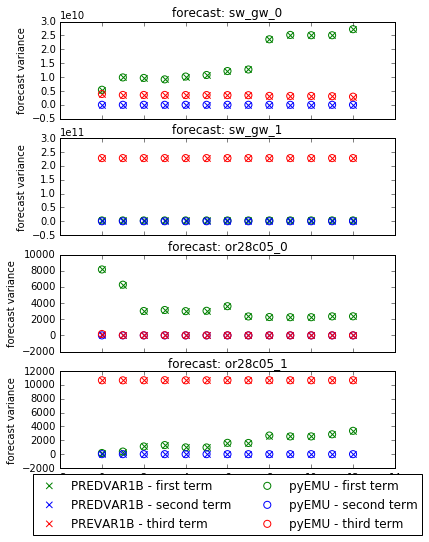

In [49]:
fig = plt.figure(figsize=(6,8))
max_idx = 13
idx = np.arange(max_idx)
for ipred,pred in enumerate(predictions):
    arr = pv1b_results[pred][:max_idx,:]
    first = df[("first", pred)][:max_idx]
    second = df[("second", pred)][:max_idx]
    third = df[("third", pred)][:max_idx]
    ax = plt.subplot(len(predictions),1,ipred+1)
    #ax.plot(arr[:,1],color='b',dashes=(6,6),lw=4,alpha=0.5)
    #ax.plot(first,color='b')
    #ax.plot(arr[:,2],color='g',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(second,color='g')
    #ax.plot(arr[:,3],color='r',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(third,color='r')
    
    ax.scatter(idx,arr[:,1],marker='x',s=40,color='g',
               label="PREDVAR1B - first term")
    ax.scatter(idx,arr[:,2],marker='x',s=40,color='b',
               label="PREDVAR1B - second term")
    ax.scatter(idx,arr[:,3],marker='x',s=40,color='r',
               label="PREVAR1B - third term")
    ax.scatter(idx,first,marker='o',facecolor='none',
               s=50,color='g',label='pyEMU - first term')
   
    ax.scatter(idx,second,marker='o',facecolor='none',
               s=50,color='b',label="pyEMU - second term")
    
    ax.scatter(idx,third,marker='o',facecolor='none',
               s=50,color='r',label="pyEMU - third term")
    ax.set_ylabel("forecast variance")
    ax.set_title("forecast: " + pred)
    if ipred == len(predictions) -1:
        ax.legend(loc="lower center",bbox_to_anchor=(0.5,-0.75),
                  scatterpoints=1,ncol=2)
        ax.set_xlabel("singular values")
    else:
        ax.set_xticklabels([])
    #break
plt.savefig("predvar1b_ver.eps")    
    

#Identifiability

In [52]:
cmd_args = [os.path.join("i64identpar.exe"),ord_base,"5",
            "null","null","ident.out","/s"]
cmd_line = ' '.join(cmd_args)+'\n'
print(cmd_line)
print(os.getcwd())
os.system(cmd_line)

i64identpar.exe freyberg_ord 5 null null ident.out /s

E:\git\pyemu\verification\Freyberg


0

In [53]:
identpar_df = pd.read_csv("ident.out",delim_whitespace=True)

In [54]:
la_ord_errvar = pyemu.ErrVar(jco=ord_base+".jco",
                             predictions=predictions,
                             verbose=False)
df = la_ord_errvar.get_identifiability_dataframe(5)
df

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,ident
rch_1,9.955541e-01,7.052885e-04,1.590869e-04,1.422682e-04,9.111534e-06,9.965699e-01
rch_2,0.000000e+00,1.109336e-31,3.728600e-31,6.933348e-33,1.083336e-32,5.015603e-31
rcond00,1.773061e-09,2.743063e-07,1.998841e-06,1.088365e-06,4.402964e-07,3.803581e-06
rcond01,4.584440e-09,6.548507e-07,4.284359e-06,2.287944e-06,8.918623e-07,8.123601e-06
rcond02,4.584440e-09,6.548507e-07,4.284359e-06,2.287944e-06,8.918623e-07,8.123601e-06
rcond03,9.277334e-09,1.267948e-06,7.720672e-06,3.952089e-06,1.396724e-06,1.434671e-05
rcond04,8.516417e-09,1.209669e-06,7.811702e-06,4.083723e-06,1.513522e-06,1.462713e-05
rcond05,4.054379e-09,6.131614e-07,4.352238e-06,2.388358e-06,9.856649e-07,8.343477e-06
rcond06,1.773061e-09,2.743063e-07,1.998841e-06,1.088365e-06,4.402964e-07,3.803581e-06
rcond07,1.627707e-11,6.855104e-10,2.667497e-10,1.078215e-09,2.344690e-09,4.391442e-09


cheap plot to verify

In [59]:
diff = identpar_df["identifiability"].values - df["ident"].values
diff.max()

4.4504227317276879e-08

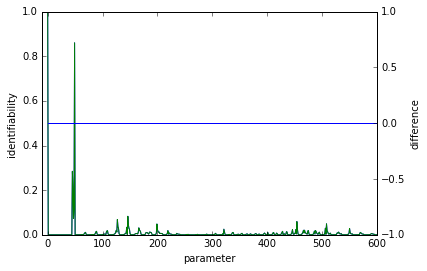

In [64]:
fig = plt.figure()
ax = plt.subplot(111)
axt = plt.twinx()
ax.plot(identpar_df["identifiability"])
ax.plot(df.ident.values)
ax.set_xlim(-10,600)
diff = identpar_df["identifiability"].values - df["ident"].values
#print(diff)
axt.plot(diff)
axt.set_ylim(-1,1)
ax.set_xlabel("parameter")
ax.set_ylabel("identifiability")
axt.set_ylabel("difference")